# Gammar/Campbell NLP assignment

## Aims

To analyse reddit posts to discover trends in healthy eating on food subreddits. We will attempt the following:

- Download a series of posts from reddit using their API
- Characterise these posts using exploratory analysis
- Predict whether a subreddit is a healthy eating subreddit based on its post content


## Why Reddit?

Reddit is a social media site where users post either links around the web or text content that they've written themselves. These posts are subject to a an upvote/downvote system which causes popular submissions to rise higher onto users' feeds. Older posts have lower weighted upvotes, resulting in a constant feed of new, highly regarded content.

Reddit's style is casual, but serious. Posts are generally typed out in full sentences with emojis and reaction images being comparatively rare. This makes it an ideal candidate for natural language processing.

## Read in data

This section is rendered as markdown rather than a code block as it takes approximately 40 minutes to run. We've provided CSVs to save you the trouble. These are to be placed in a `data/` subdirectory. Multireddits are groups of subreddits grouped by a common theme. We did a Google search for a "food multireddit" and [came across a general one](https://www.reddit.com/r/Cooking/comments/cg7lha/misc_heres_all_of_the_food_related_subreddits_i/) made by Reddit user [Nomeii](https://www.reddit.com/user/Nomeii/).

We used the [Python Reddit API Wrapper (praw)](https://praw.readthedocs.io/en/stable/index.html) to loop through each of these subreddits picking the top 1000 most upvoted posts from the past year. We saved this as a csv and will be using this as the base of our of our future analysis.

```python
import praw
import pandas as pd
import datetime as time
from colorama import Fore, Style
from pathlib import Path

# Make data directory for newly written data if it doesn't already exist
DATA_DIRECTORY = "data/"
Path(DATA_DIRECTORY).mkdir(parents=True, exist_ok=True)

POST_TIME_PERIOD = "year"

# Number of posts per subreddit to pull
N_TITLES = 1000

#Obtained from praw.ini file in working directory
reddit = praw.Reddit("uls-healthyeating", check_for_async=False)

# Chose this multireddit as it has many food subreddits
food_multireddit = reddit.multireddit(name="food", redditor = "nomeii")

top_dict = {"subreddit" : [],
            "title" : [],
            "is_self" : [],
            "selftext" : [],
            "author" : [],
            "url" : [],
            "score" : [],
            "upvote_ratio" : [],
            "n_gilded" : [],
            "num_comments" : [],
            "permalink" : [],
            "created_utc" : []
            }

# Cycle over each of the subreddits, grab posts and append it to the
# global dictionary

for index,subreddit in enumerate(food_multireddit.subreddits):
    subreddit_name = subreddit.display_name
    
    #Subreddits to appear in red
    print("\n[", time.datetime.now(), "]", f"{Fore.RED}****{subreddit_name}****{Style.RESET_ALL}")
    print(f"Subreddit number: {index}")
    
    subreddit_data = subreddit.top(limit=N_TITLES, time_filter=POST_TIME_PERIOD)
    
    for post in subreddit_data:
        
        top_dict["subreddit"].append(subreddit_name)
        top_dict["title"].append(post.title)
        top_dict["is_self"].append(post.is_self)
        top_dict["selftext"].append(post.selftext)
        top_dict["author"].append(None if post.author is None else post.author.name)
        top_dict["url"].append(post.url)
        top_dict["score"].append(post.score)
        top_dict["upvote_ratio"].append(post.upvote_ratio)
        top_dict["n_gilded"].append(post.gilded)
        top_dict["num_comments"].append(post.num_comments)
        top_dict["permalink"].append(post.permalink)
        top_dict["created_utc"].append(post.created_utc)
    
# Combine dictionary into one large dataframe    
top_df = pd.DataFrame(top_dict)

top_df.to_csv(DATA_DIRECTORY + "reddit_data.csv", index = False)
```

## Data description

The Reddit data is a 13-column dataset with ~70K rows. It contains among others: post titles, author names, subreddit names, upvote scores, post time and post text where available. We retrieved it from the Reddit API on 2023-03-08 as of the most recent update.

We've also manually made a mapping between each of the subreddits and our expert opinion as to if the subreddit relates to healthy eating. Subreddits explicitly about healthy eating and plant-based diets were considered healthy as well as home-cooking subreddits. We made this mapping to facilitate supervised learning in our models.

## Data exploration

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


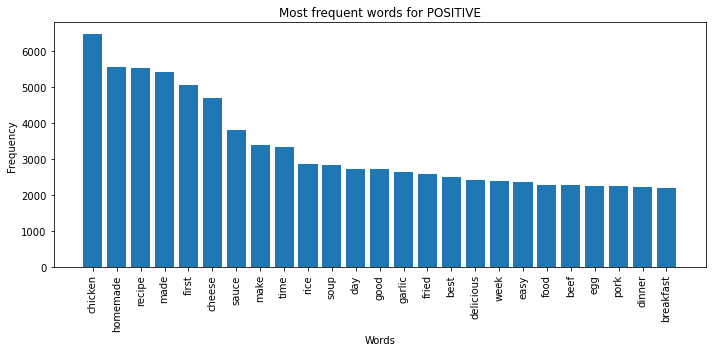

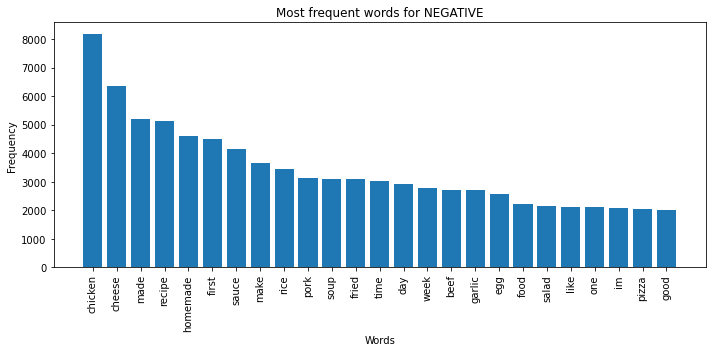

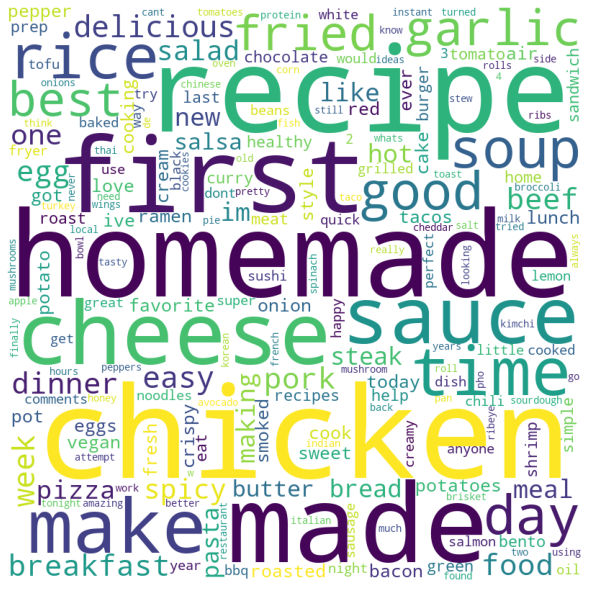

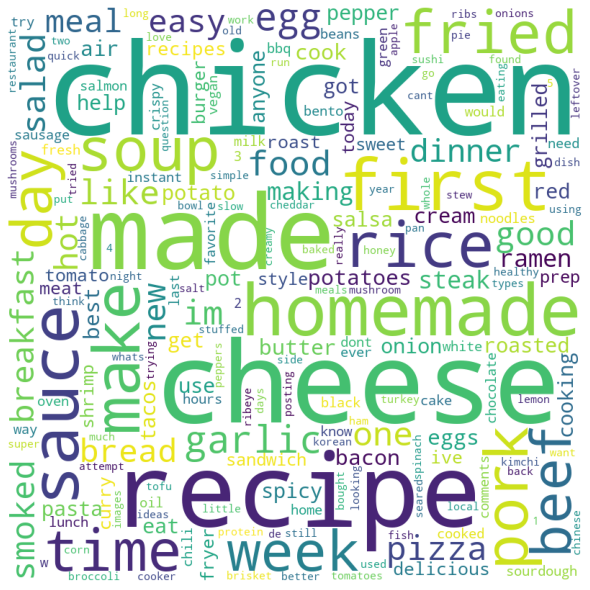

In [2]:
import csv
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download the stopwords corpus
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Open the CSV file for reading
with open('data/reddit_data_sentiment.csv', 'r', encoding='utf-8') as input_file:

    # Create a CSV reader object
    reader = csv.reader(input_file, delimiter=',')

    # Create an empty list to hold the words
    words_nature1 = []
    words_nature2 = []

    # Define stopwords to remove
    stop_words = set(stopwords.words('english'))

    # Iterate through each row of the CSV file
    for row in reader:

        # Remove links and punctuation marks
        text = re.sub(r'http\S+', '', row[1])
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenize the text using word_tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and demonstrative words
        filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in ['this', 'that', 'these', 'those']]

          # Determine the nature of the row
        label = row[13]

        # Add the filtered tokens to the appropriate list based on the nature
        if label == 'POSITIVE':
            words_nature1.extend(filtered_tokens)
        elif label == 'NEGATIVE':
            words_nature2.extend(filtered_tokens)
      
        # Add the filtered tokens to the words list
        words_nature1.extend(filtered_tokens)
        words_nature2.extend(filtered_tokens)
# Create frequency distributions for each nature
freq_dist_nature1 = FreqDist(words_nature1)
freq_dist_nature2 = FreqDist(words_nature2)


# Get the 25 most frequent words and least frequent words for each nature
most_frequent_words_nature1 = freq_dist_nature1.most_common(25)
most_frequent_words_nature2 = freq_dist_nature2.most_common(25)


# Create a bar graph for the most frequent words for each nature
plt.figure(figsize=(10,5))
plt.bar([word[0] for word in most_frequent_words_nature1], [word[1] for word in most_frequent_words_nature1])
plt.xticks(rotation=90)
plt.title("Most frequent words for POSITIVE")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("bar_graph_most_frequent_POSITIVE.png")

plt.figure(figsize=(10,5))
plt.bar([word[0] for word in most_frequent_words_nature2], [word[1] for word in most_frequent_words_nature2])
plt.xticks(rotation=90)
plt.title("Most frequent words for NEGATIVE")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("bar_graph_most_frequent_NEGATIVE.png")

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(freq_dist_nature1)
wordcloud2 = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(freq_dist_nature2) 
# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the word cloud as a PNG file
plt.savefig("wordcloud2.png")
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)

# Save the word cloud as a PNG file
plt.savefig("wordcloud.png")

# Show the plots
plt.show()

We notice that there are really close similarities between the most frequent words in positive and negative posts for starters chicken is the most frequently used words in both sets of data and most of the words that appear in the charts are the same. It is surprising that rice, soup and salad appear in the negative subset and fried to appear in the positive subset this shows that other than the nature of our analysis food terms are hard to assign to a category different types of food can be healthy just as they can be unhealthy and positive and negative sentiment towards food is highly subjective as they're not chosen by 
their value rather mostly by taste.

## Modelling healthy-eating subreddits

For this task, we wanted to perform a supervised classification model. We decided on logistic regression from `scikit-learn` as we could validate the results with a more statistical approach as well. We want to see if we can predict if a post comes from a "healthy" subreddit based only on its upvote ratio, whether it's a self post or its sentiment.

### Sentiment analysis

We needed more variables and also needed a way to include our text variables. A positive/negative sentiment would constitue an additional variable and there are already pretrained models that allowing us to perform this without the need to process billions of records to create a satisfactory model. We used the `distilbert-base-uncased-finetuned-sst-2-english` model on the post titles in our data. Again, this process took over an hour on m machine so the following is markdown rather than a code chunk.

```python
from transformers import pipeline
import pandas as pd
import datetime as time

# We're using sentiment analysis to classify post titles so that we can use 
# that to help us to predict posts as healthy or not

classifier = pipeline("sentiment-analysis",
                      "distilbert-base-uncased-finetuned-sst-2-english")

# Read in our reddit data and healthiness classifier
raw_data = pd.read_csv("data/raw_reddit_data.csv")
subreddit_health = pd.read_csv("data/subreddit_health.csv")

# Merge assessment of subreddit health with subreddit data
reddit_data = raw_data.merge(subreddit_health, on="subreddit")

# Run sentiment analysis on each element
## This takes a long time so we make note of the start and stop time
print(time.datetime.now())
reddit_data.loc[:, ('label', 'score')] = reddit_data.title.apply(
    classifier).explode().apply(pd.Series)
print(time.datetime.now())

# This takes a long time so we make _sure_ that the result is saved
reddit_data.to_csv("data/reddit_data_sentiment.csv", index=False)
```

### Logistic regression

We're using the `LogisticRegression` model from `sklearn` for the model `is_subreddit_healthy ~ upvote_ratio + is_self_post + has_positive_title`.
Our data has "Healthy", "Neutral" and "Unhealthy" categories, but to keep the model simple, we've lumped Neutral and Unhealthy together into one. We split the data into a training set and a validation set with a 20% split to validation.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from statsmodels.formula.api import logit

sentiment_data = pd.read_csv("data/reddit_data_sentiment.csv")

def sentiment2int(sentiment):
    if sentiment == "NEGATIVE":
        return(False)
    if sentiment == "POSITIVE":
        return(True)


def nature2int(nature):
    if nature == "Unhealthy":
        return(False)
    if nature == "Neutral":
        return(False)
    if nature == "Healthy":
        return(True)

X = sentiment_data.loc[:, ("upvote_ratio", "is_self", "label")]
#Change sentiments to logical
X["title_is_positive"] = [sentiment2int(sentiment) for sentiment in X["label"]]
X.drop("label", axis = 1, inplace = True)

Y = pd.Series([nature2int(nature) for nature in sentiment_data.loc[:, "nature"]], name = "nature")

# Split into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)


base_lr = LogisticRegression(solver='liblinear') #liblinear dumps everything in one category

model = base_lr.fit(X_train, Y_train)

It's here that we have our first surprise when we look at the confusion matrix:

In [ ]:
confusion_matrix(Y_train, model.predict(X_train))

The most effective model is one where we just flat out assume that all posts are characterised as unhealthy. I didn't believe it at first, but if we look at how to predicts on its training set:

In [ ]:
any(model.predict(X_train))

They are definitely all False. Maybe we'll get different results on the validation set?

In [ ]:
any(model.predict(X_test))

Same result. Perhaps there is no relationship between the variables. We don't really have a measure of that in our model. In order work that out, we'll have to use more classical statistical techniques.

### Statistical logistic regression

The more classical approach use a logit curve. We're going to use the framework from `statsmodels`

In [ ]:
logit_data = pd.concat([Y_train, X_train], axis = 1)

# Convert bools to int so statsmodels can process it
logit_data["nature"] = logit_data.nature.apply(int)
logit_data["is_self"] = logit_data.is_self.apply(int)
logit_data["title_is_positive"] = logit_data.title_is_positive.apply(int)

logit_model = logit("nature ~ upvote_ratio + is_self + title_is_positive", logit_data)
#logit_model = sm.Logit(np.array(Y_train),X_train)

result = logit_model.fit()
result.pred_table()

Hmm, same result. That's a good sign. Let's see if we were correct about there being no relationship between the variables

In [ ]:
print(result.summary())

Not at all. There seems to be a strong relationship with each of them (except `is_self`). It seems like a relatively complex model that leads to a simple result. Not what we were hoping for, but an interesting result nonetheless. 

## Future avenues of research

### Larger text samples

We only really use the titles in our analysis despite the fact that text posts are available. We opted not to use them as some subreddits don't allow them or only allow them which could have confused our results. We could also have crawled all the links, allowing us to retrieve even more text. We also could have retrieve comments which would have provided us with a real wealth of text.

### More detailed sentiment analysis

We used sentiment analysis in a really cursory way, but there's a lot more to be unpacked. We don't really which words are causing positive/negative sentiments and if those words are specific to healthy food subreddits. For example, certain insults may be restricted to healthy/unhealthy subreddits. [Certain models](https://huggingface.co/michellejieli/emotion_text_classifier) have more detailed sentiments. We could examine the relationship between healthy food and feelings of disgust, for instance.

### Unsupervised determination of what healthy means

With fewer than 100 subreddits, it was possible to determine which were healthy and which weren't. An unsupervised classifier might better be able to determine this and perhaps find a more logical grouping. Given the difficulties we had with defining it, perhaps "Healthy eating" isn't a true natural group and it bleeds over with home cooking and vegetarianism. Perhaps there's a real distinction between gym bros and detoxers despite the fact that they would both consider themselves to be into "healthy eating". 